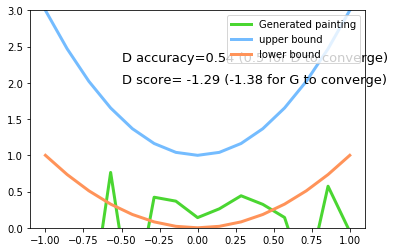

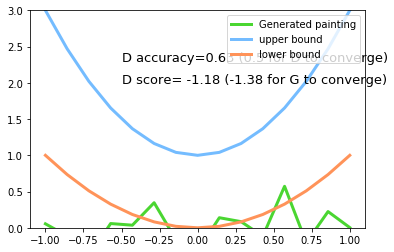

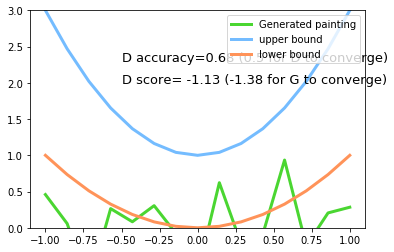

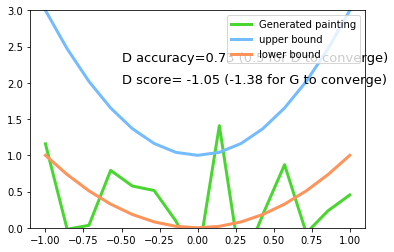

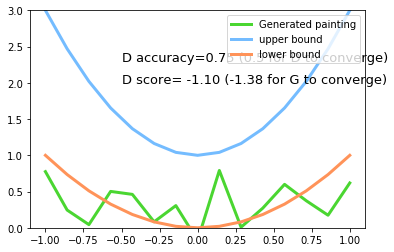

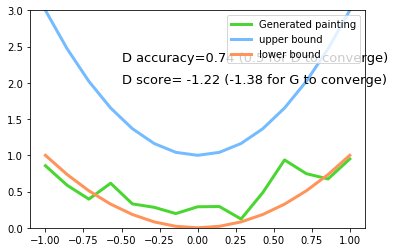

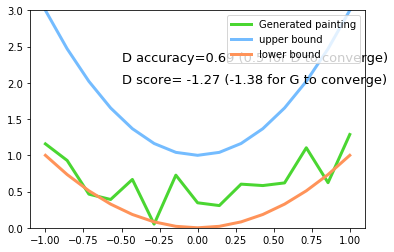

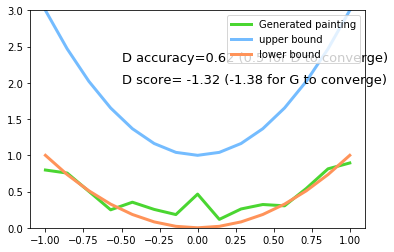

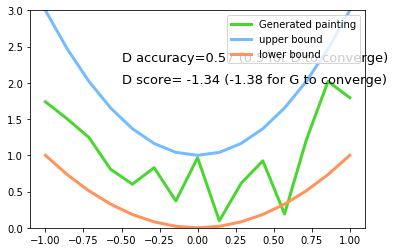

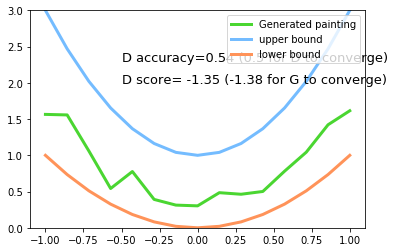

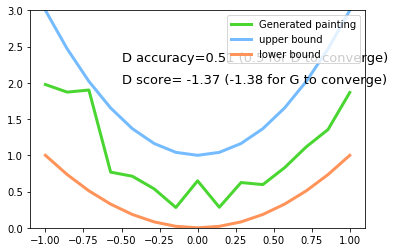

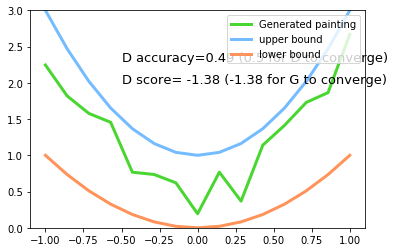

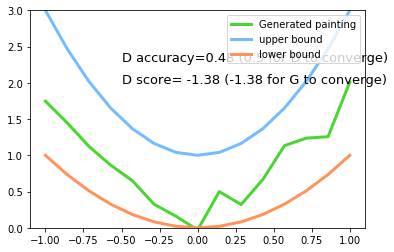

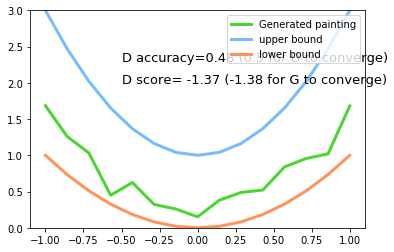

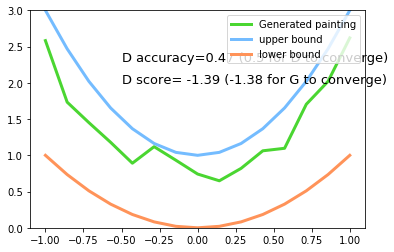

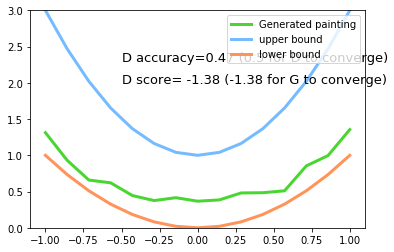

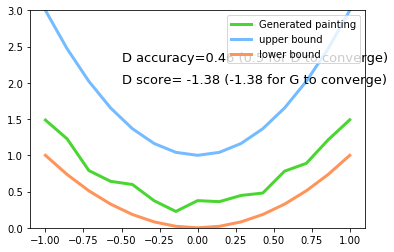

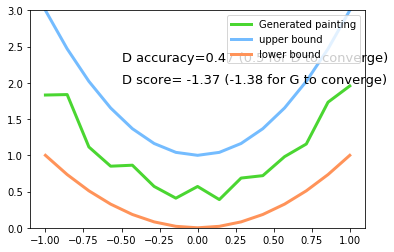

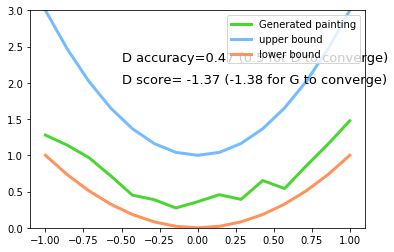

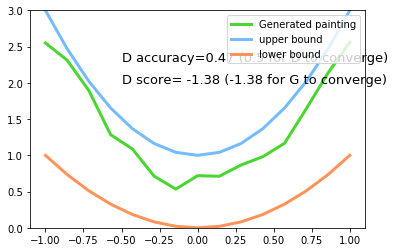

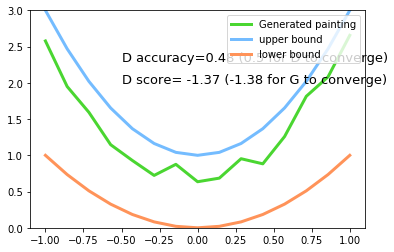

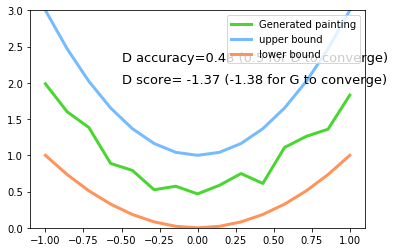

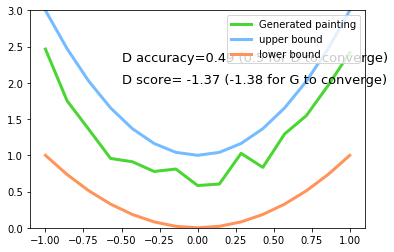

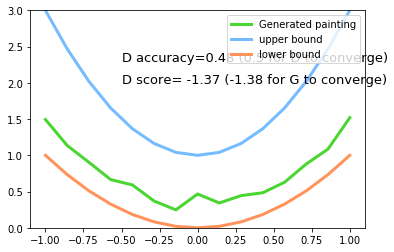

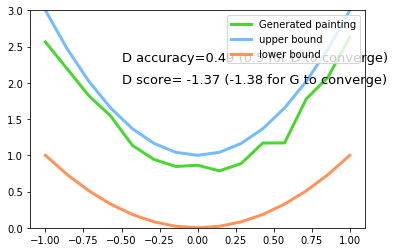

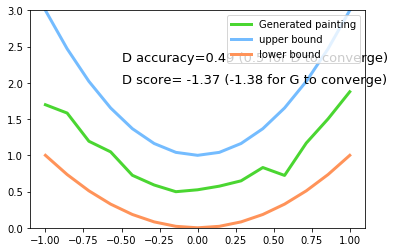

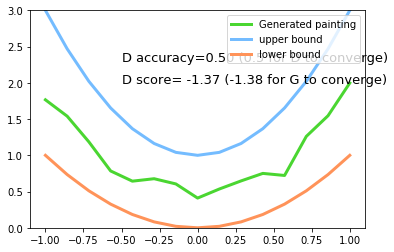

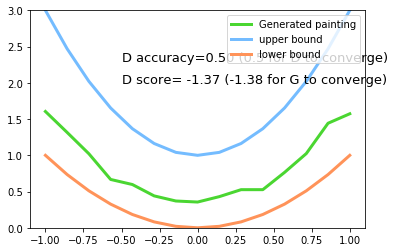

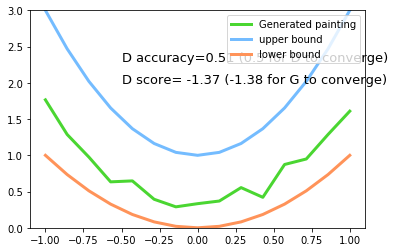

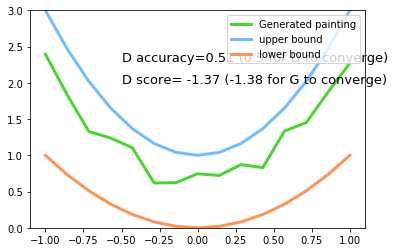

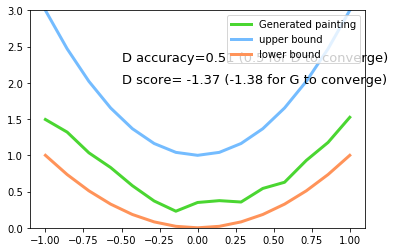

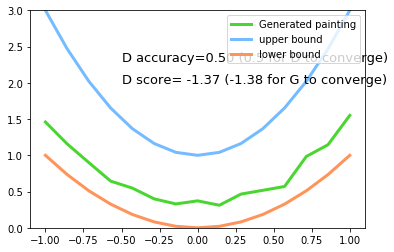

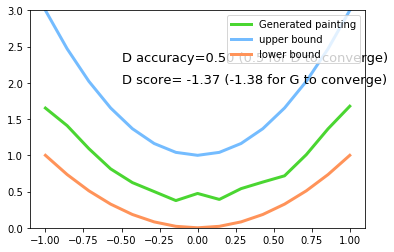

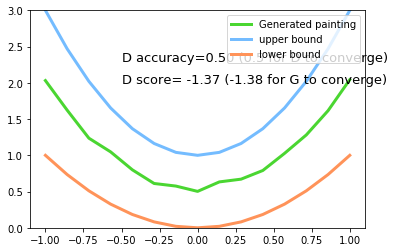

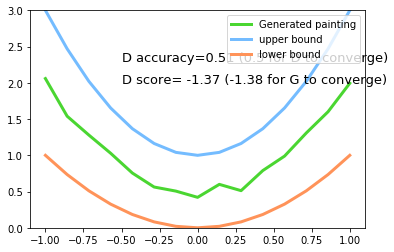

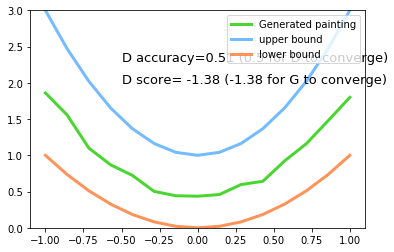

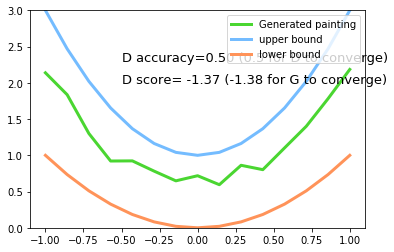

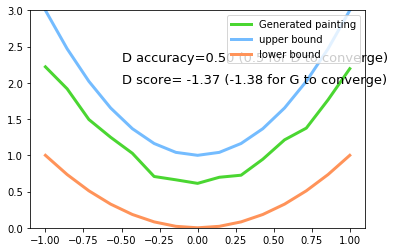

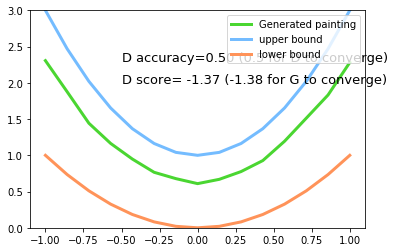

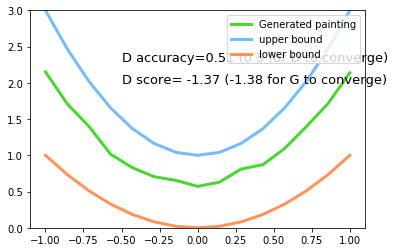

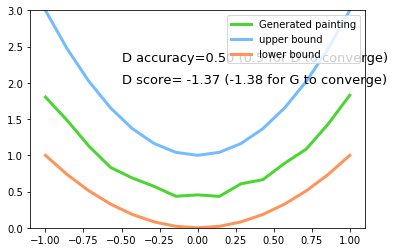

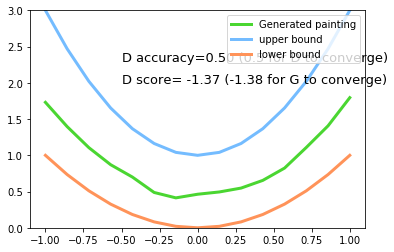

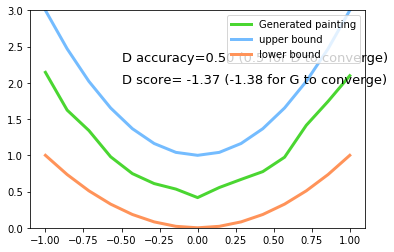

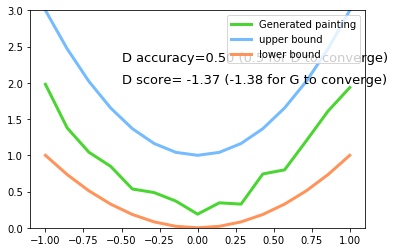

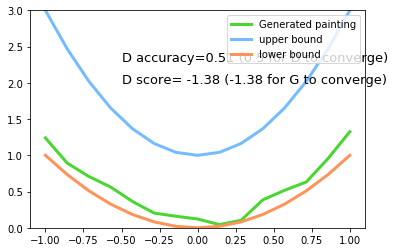

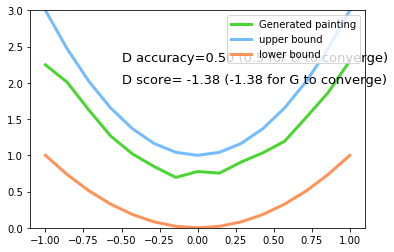

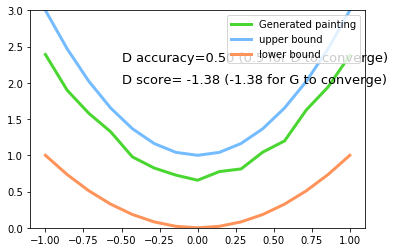

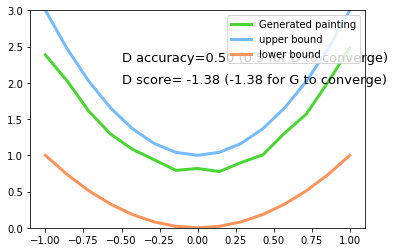

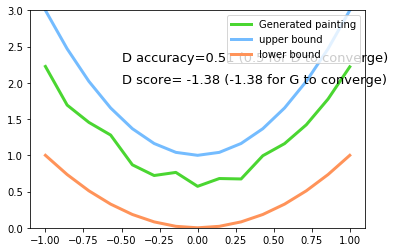

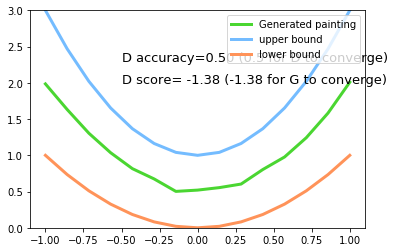

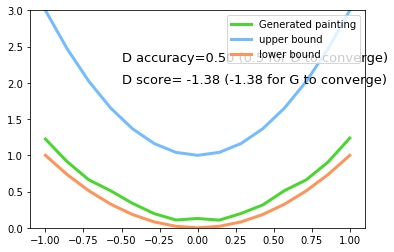

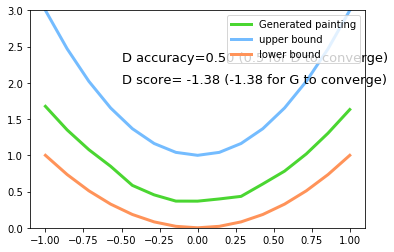

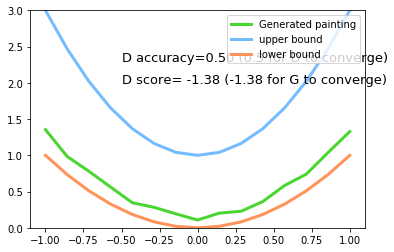

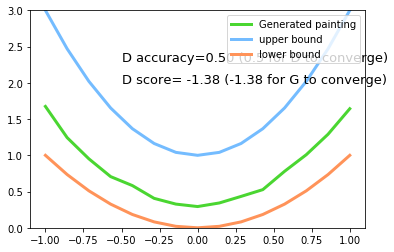

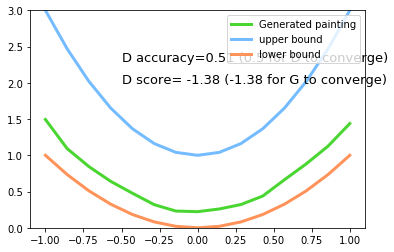

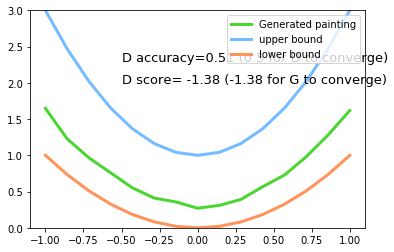

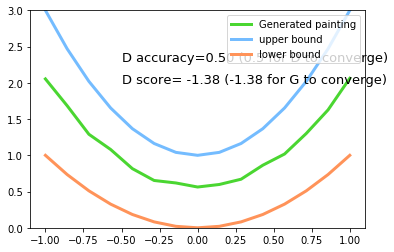

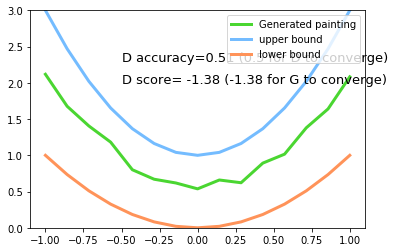

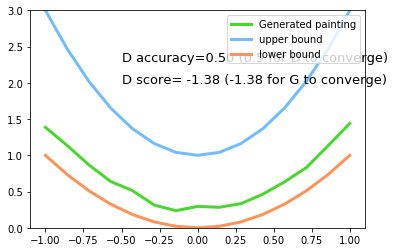

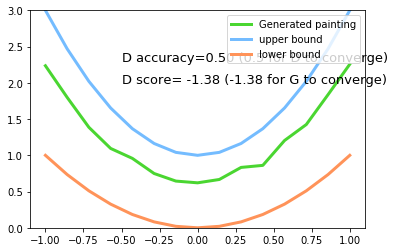

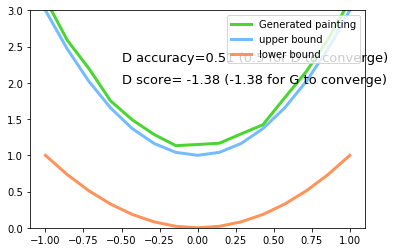

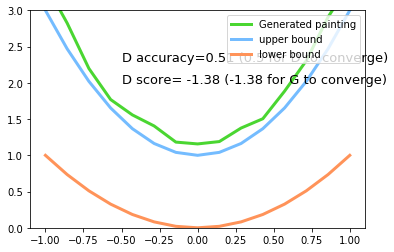

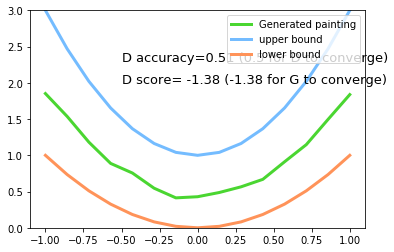

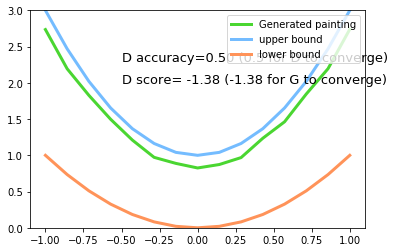

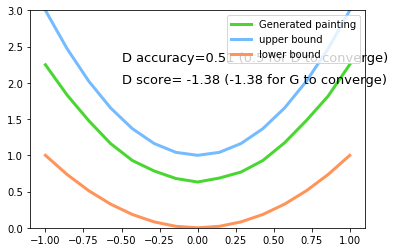

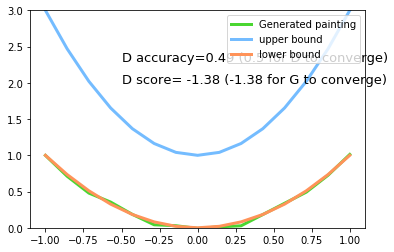

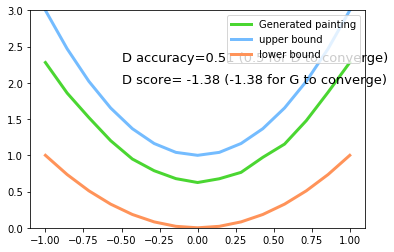

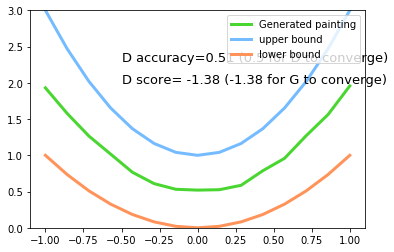

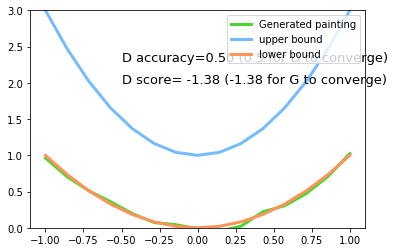

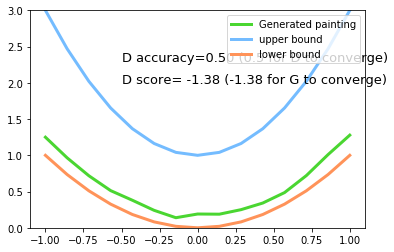

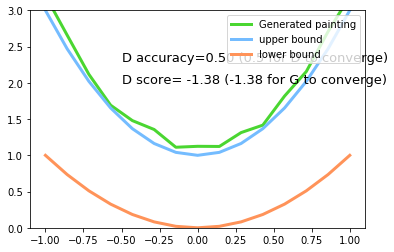

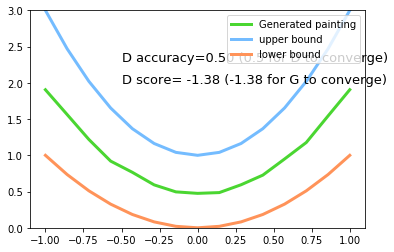

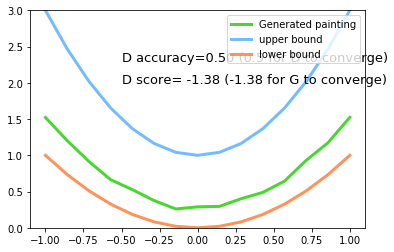

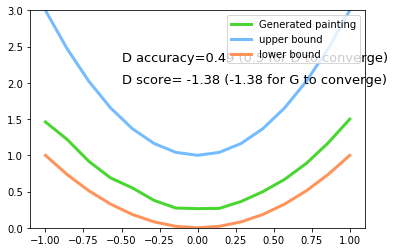

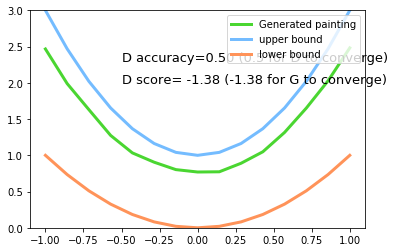

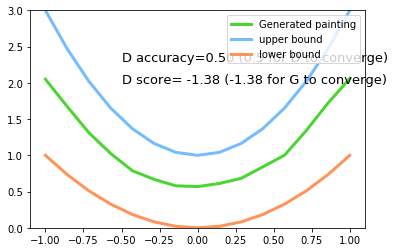

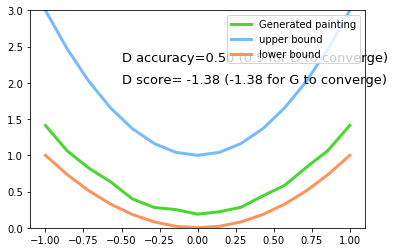

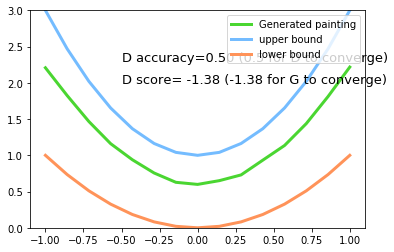

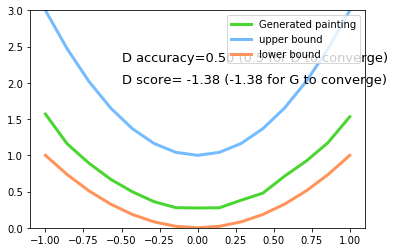

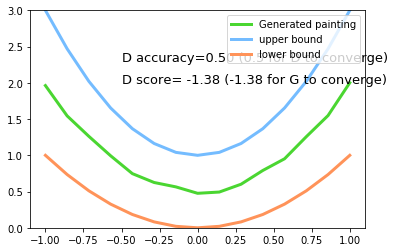

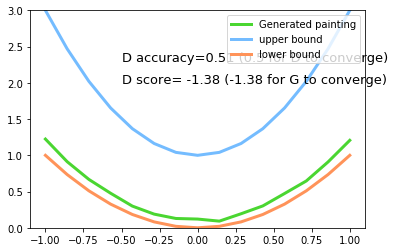

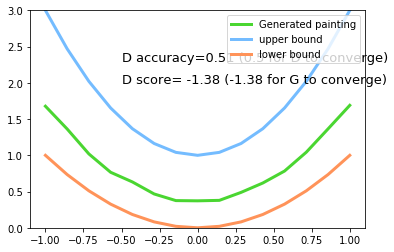

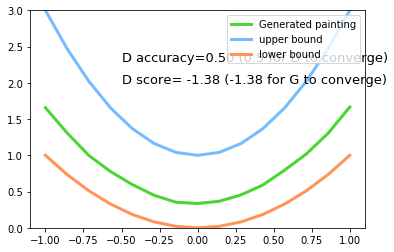

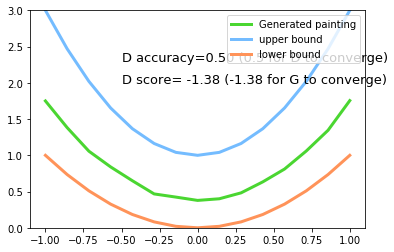

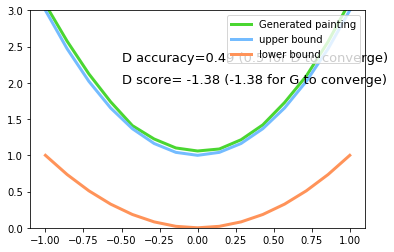

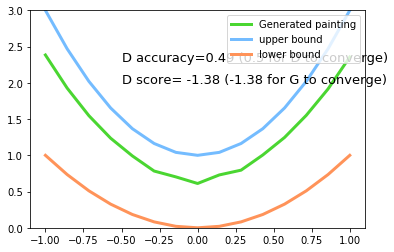

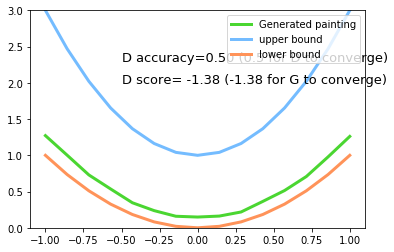

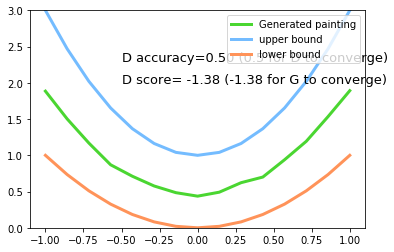

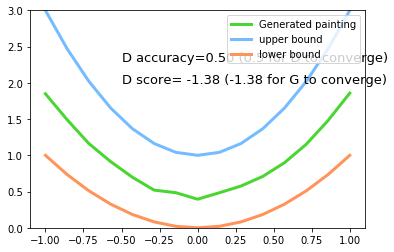

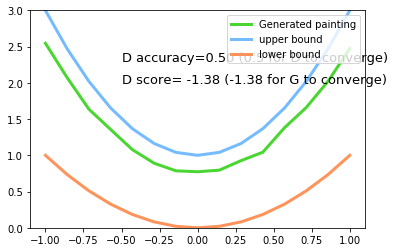

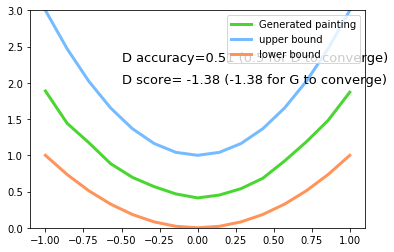

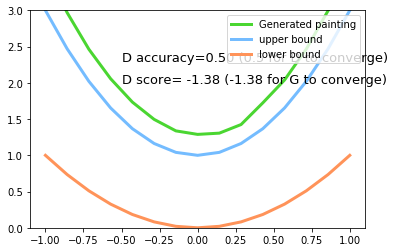

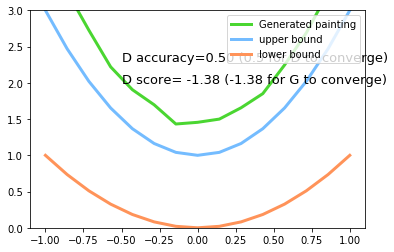

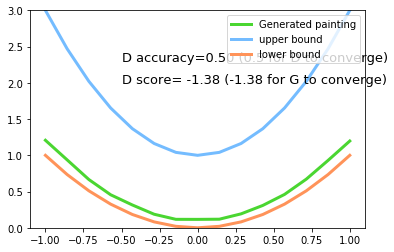

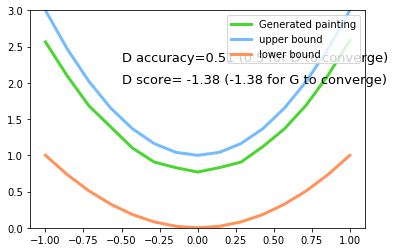

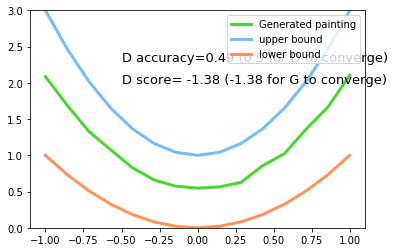

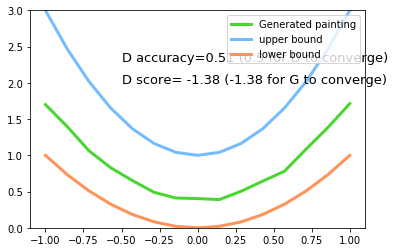

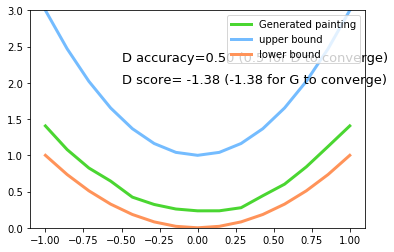

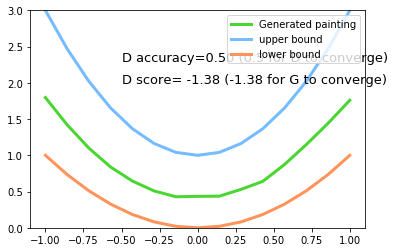

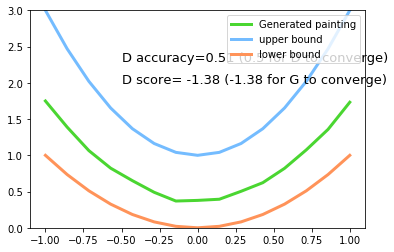

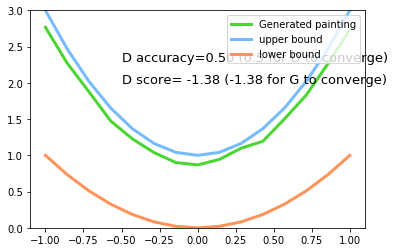

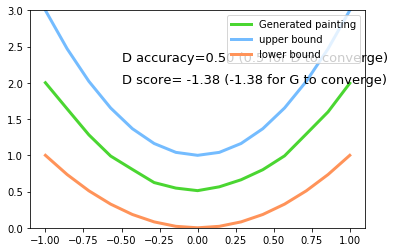

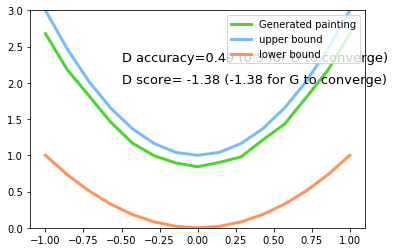

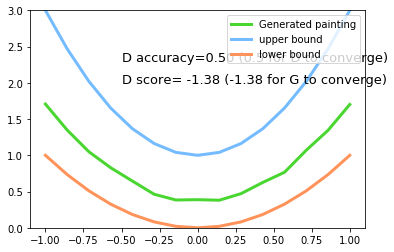

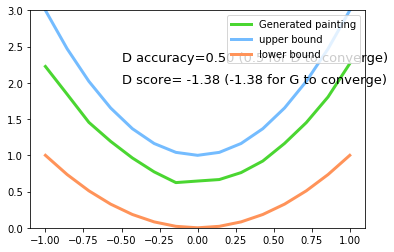

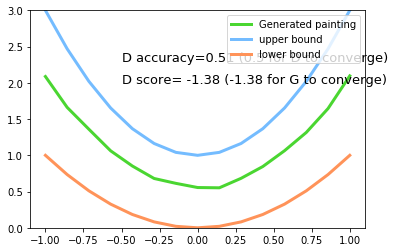

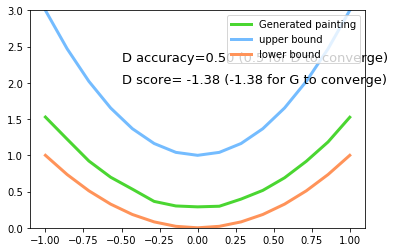

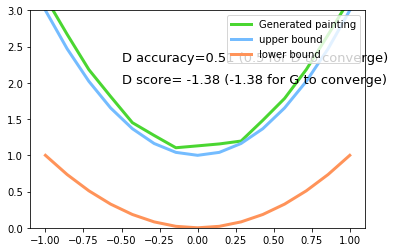

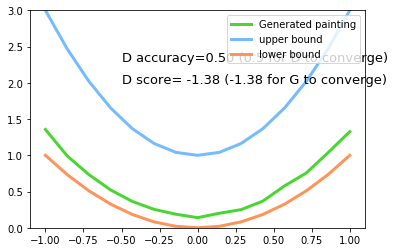

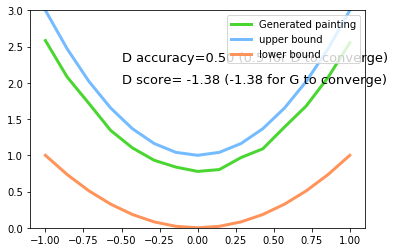

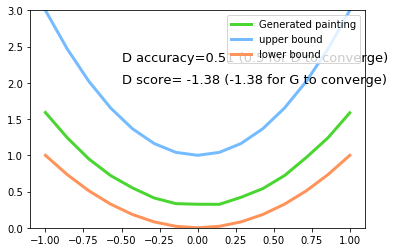

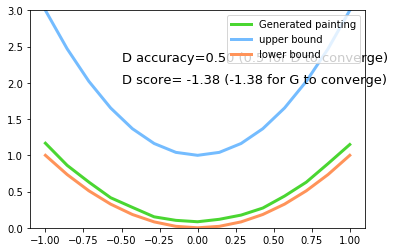

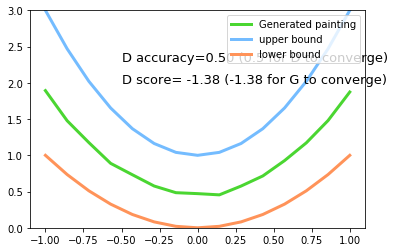

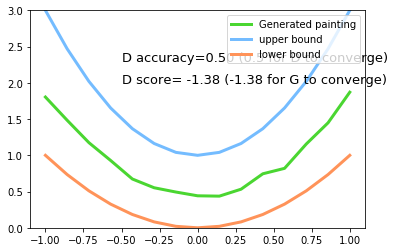

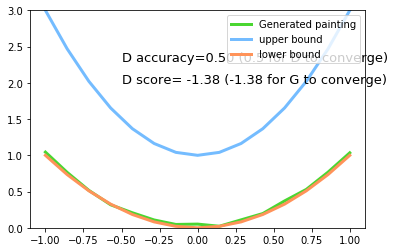

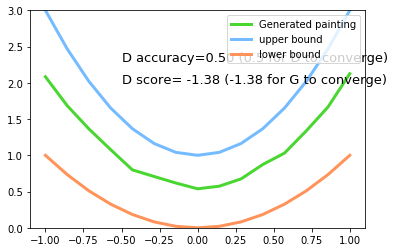

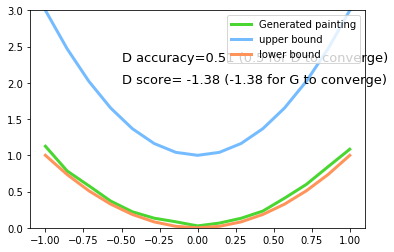

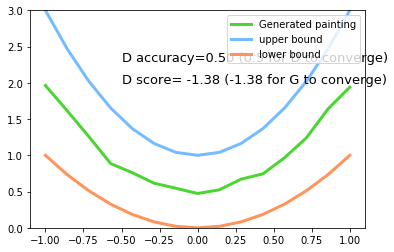

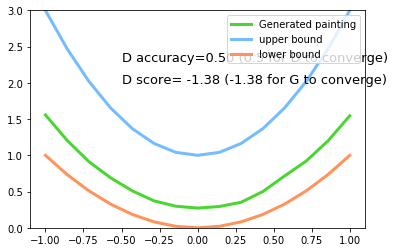

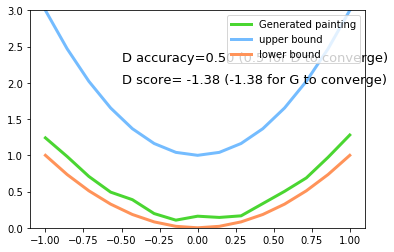

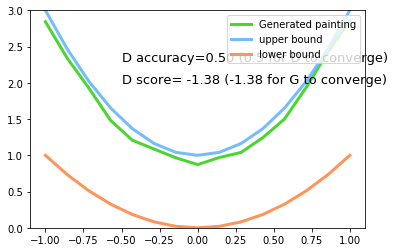

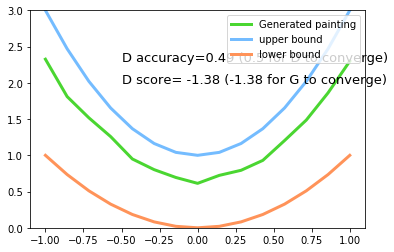

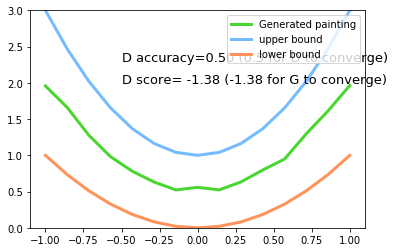

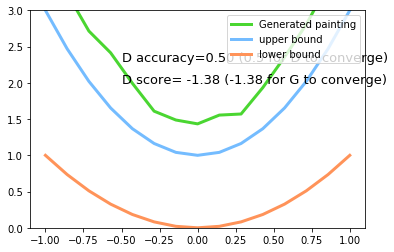

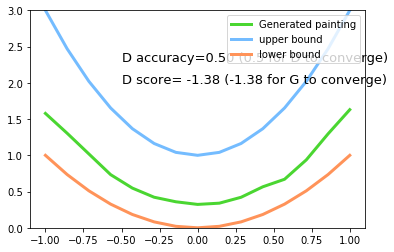

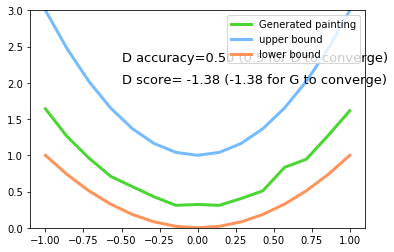

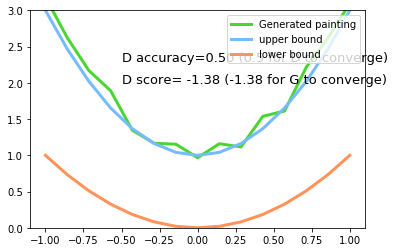

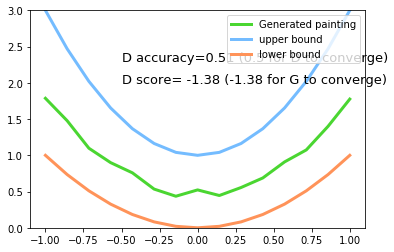

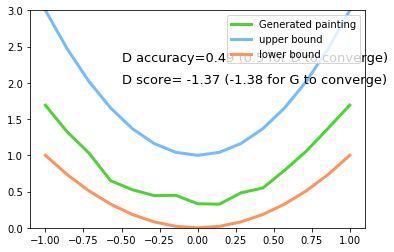

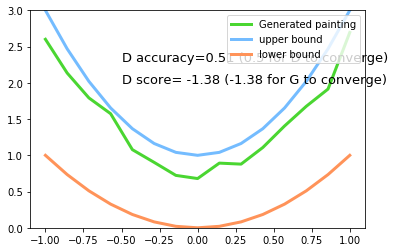

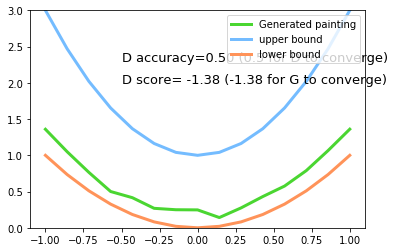

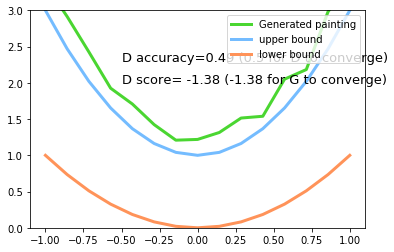

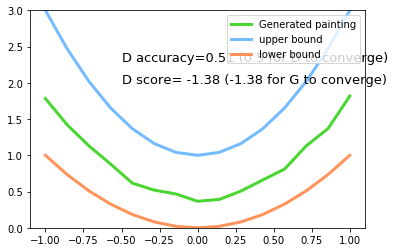

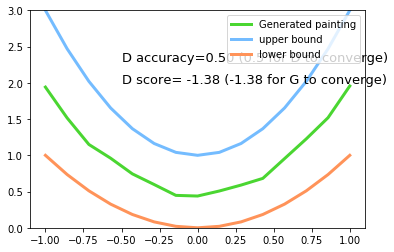

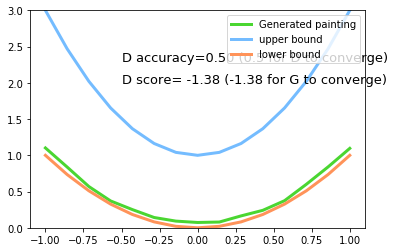

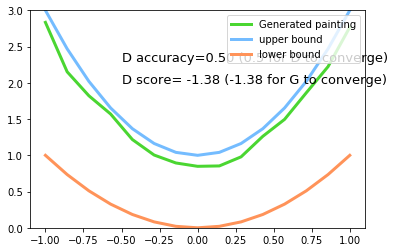

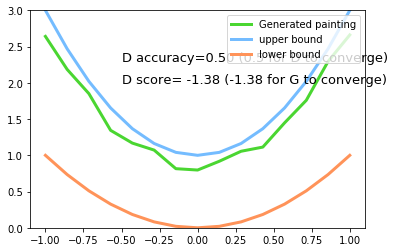

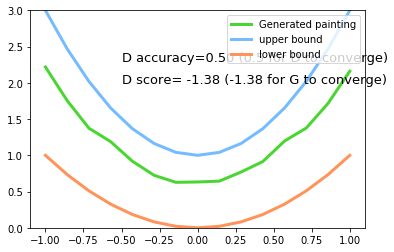

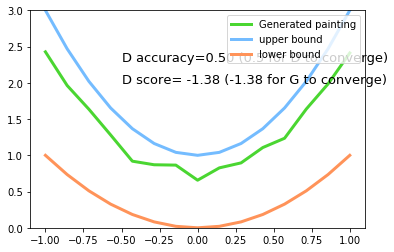

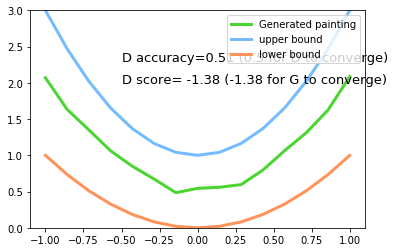

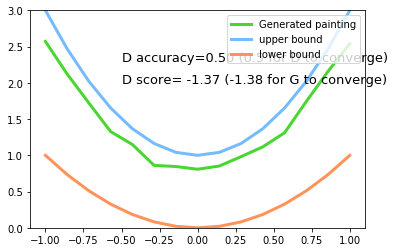

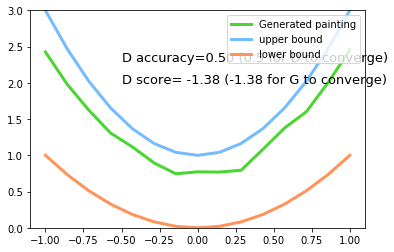

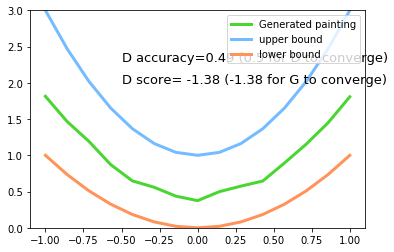

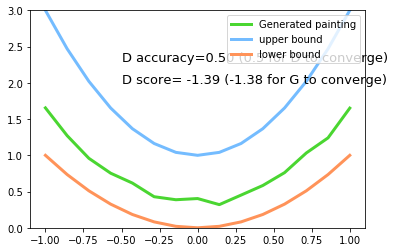

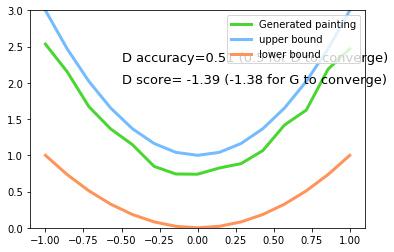

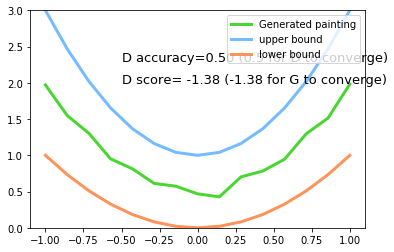

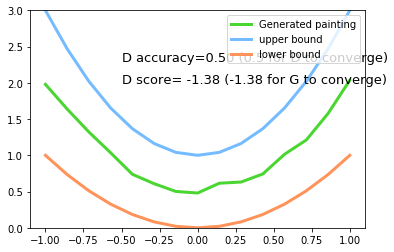

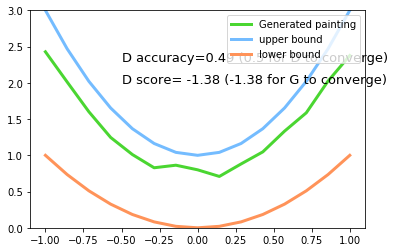

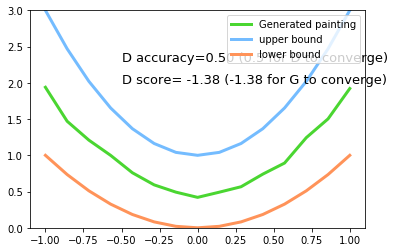

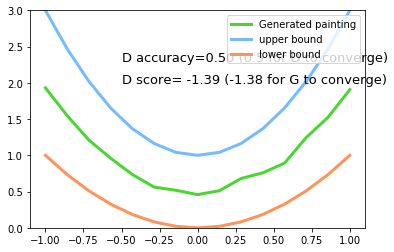

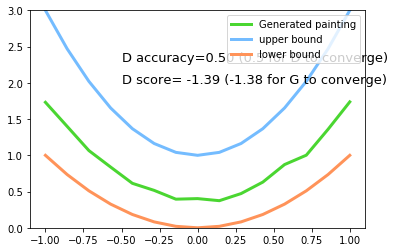

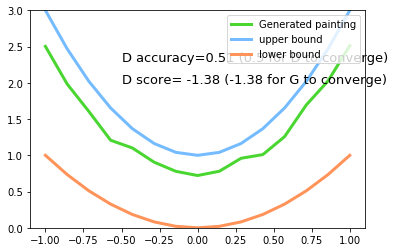

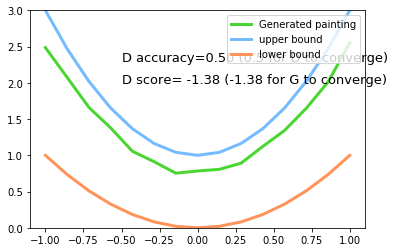

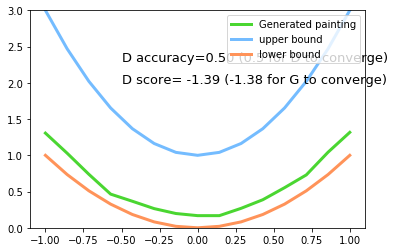

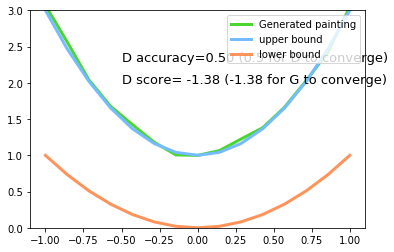

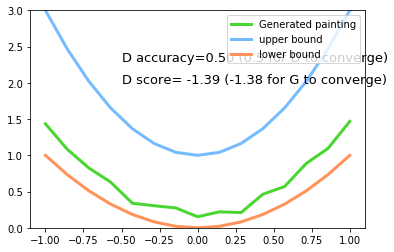

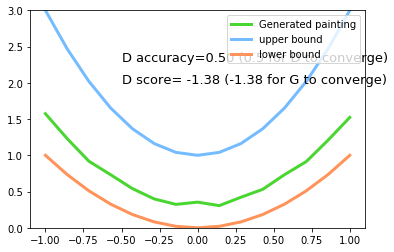

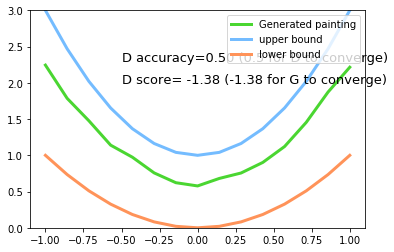

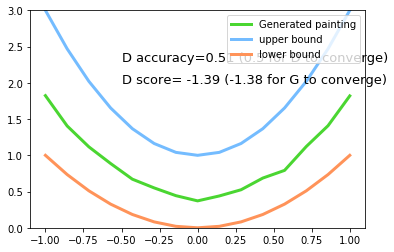

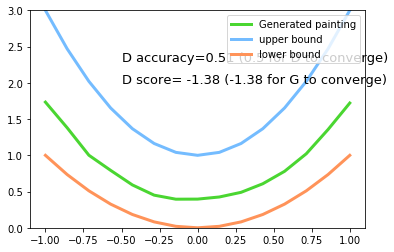

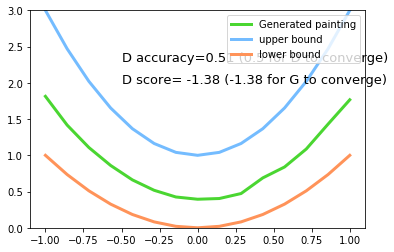

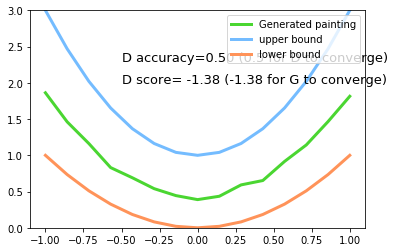

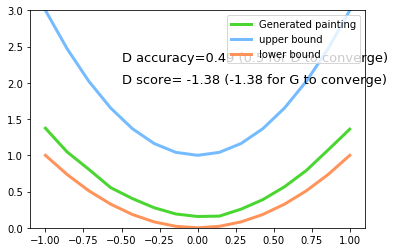

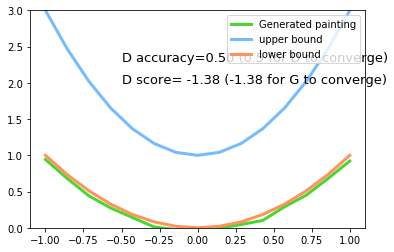

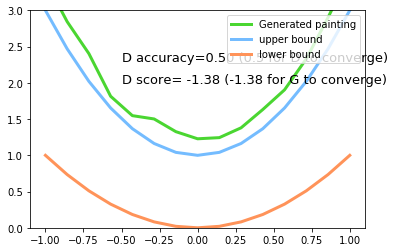

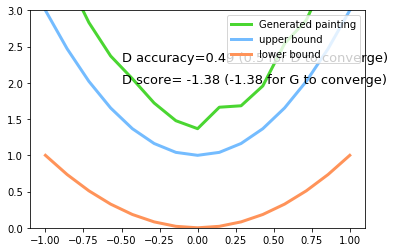

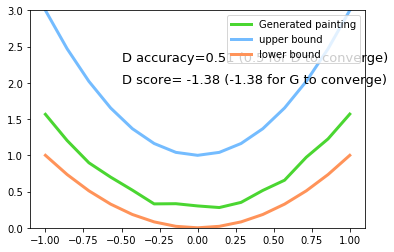

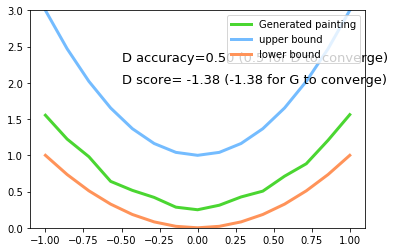

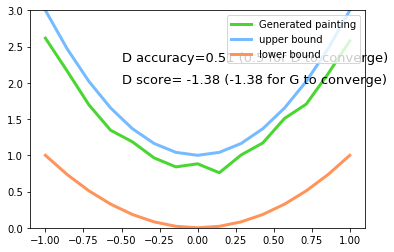

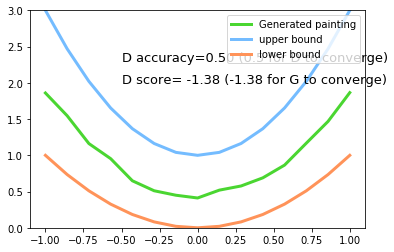

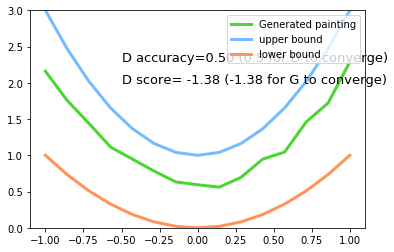

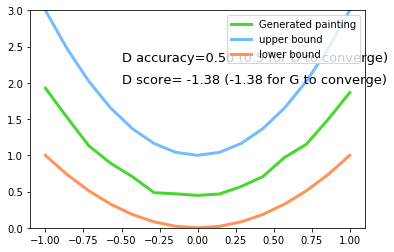

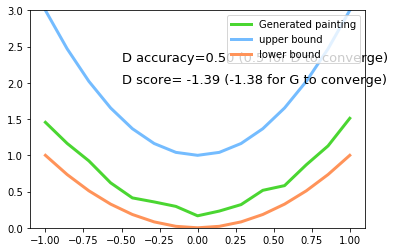

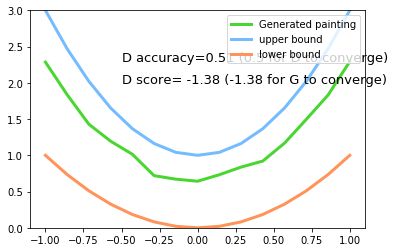

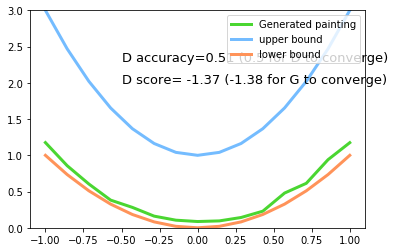

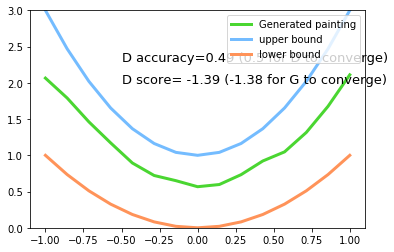

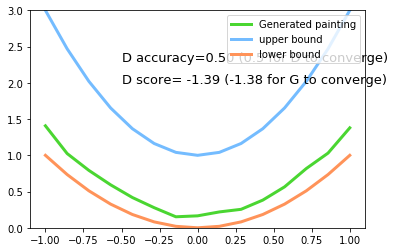

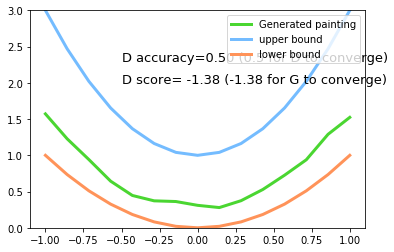

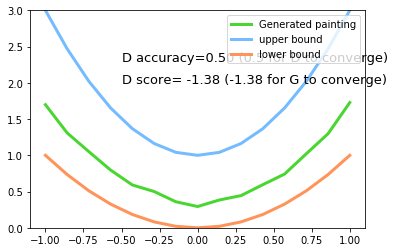

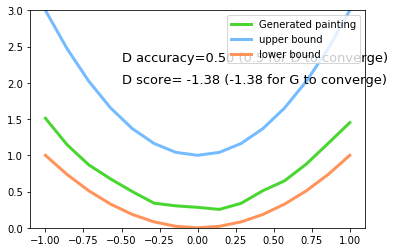

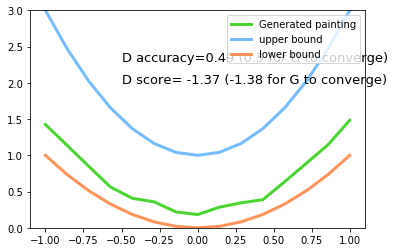

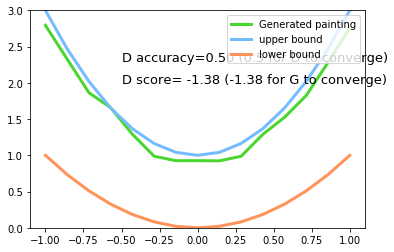

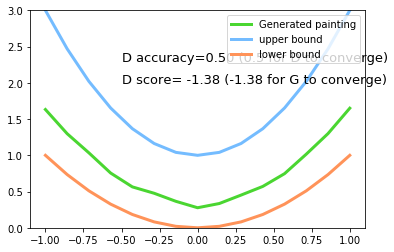

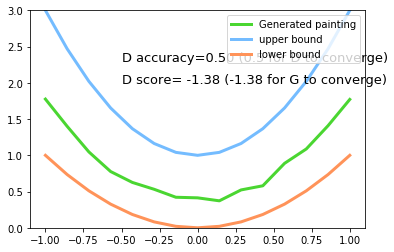

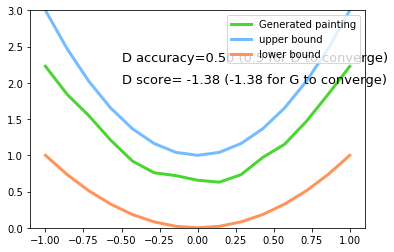

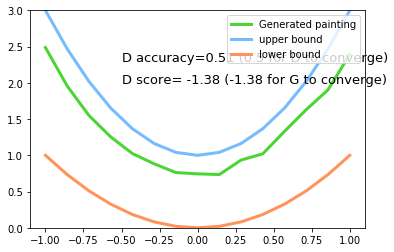

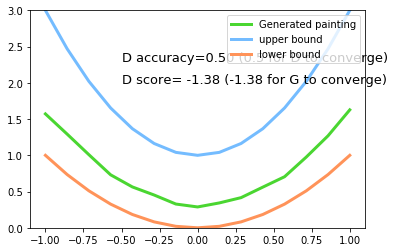

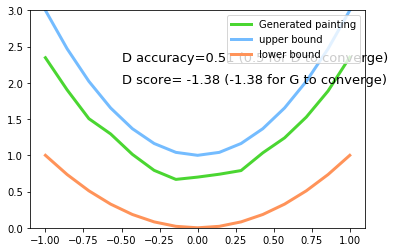

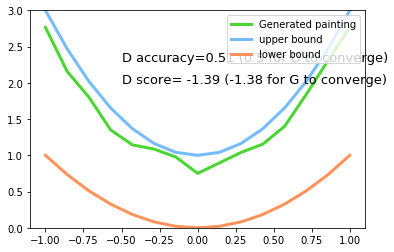

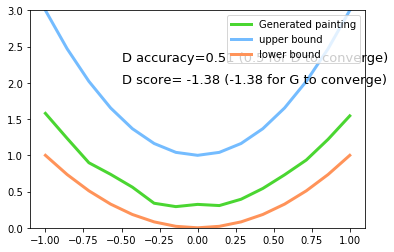

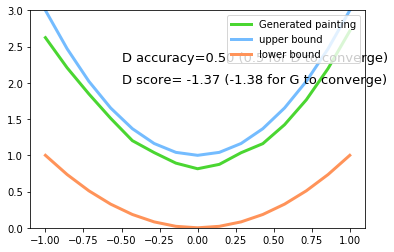

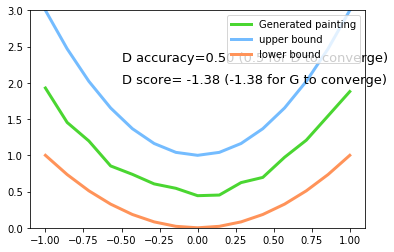

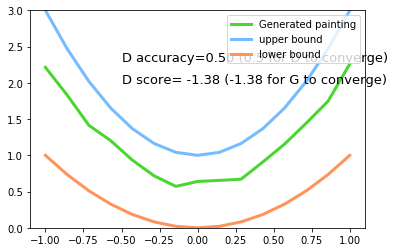

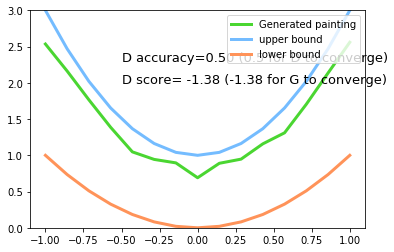

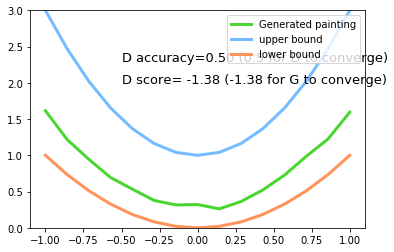

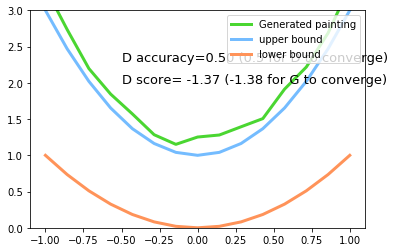

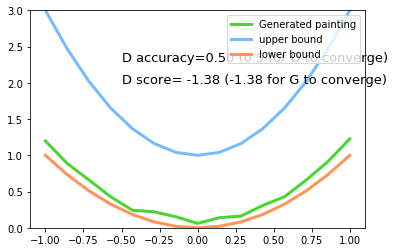

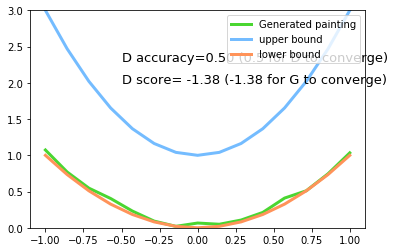

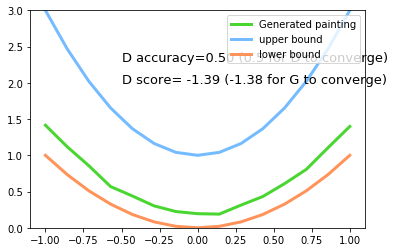

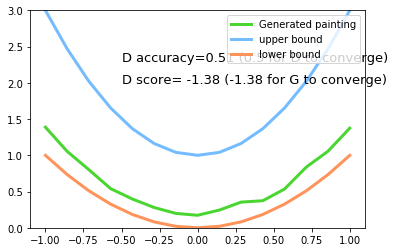

In [4]:
"""
View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
Dependencies:
torch: 0.4
numpy
matplotlib
"""
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible
# np.random.seed(1)

# Hyper Parameters
BATCH_SIZE = 64
LR_G = 0.0001           # learning rate for generator
LR_D = 0.0001           # learning rate for discriminator
N_IDEAS = 5             # think of this as number of ideas for generating an art work (Generator)
ART_COMPONENTS = 15     # it could be total point G can draw in the canvas
PAINT_POINTS = np.vstack([np.linspace(-1, 1, ART_COMPONENTS) for _ in range(BATCH_SIZE)])

# show our beautiful painting range
# plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
# plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
# plt.legend(loc='upper right')
# plt.show()


def artist_works():     # painting from the famous artist (real target)
    a = np.random.uniform(1, 2, size=BATCH_SIZE)[:, np.newaxis]
    paintings = a * np.power(PAINT_POINTS, 2) + (a-1)
    paintings = torch.from_numpy(paintings).float()
    return paintings

G = nn.Sequential(                      # Generator
    nn.Linear(N_IDEAS, 128),            # random ideas (could from normal distribution)
    nn.ReLU(),
    nn.Linear(128, ART_COMPONENTS),     # making a painting from these random ideas
)

D = nn.Sequential(                      # Discriminator
    nn.Linear(ART_COMPONENTS, 128),     # receive art work either from the famous artist or a newbie like G
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid(),                       # tell the probability that the art work is made by artist
)

opt_D = torch.optim.Adam(D.parameters(), lr=LR_D)
opt_G = torch.optim.Adam(G.parameters(), lr=LR_G)

plt.ion()   # something about continuous plotting

for step in range(10000):
    artist_paintings = artist_works()           # real painting from artist
    G_ideas = torch.randn(BATCH_SIZE, N_IDEAS)  # random ideas
    G_paintings = G(G_ideas)                    # fake painting from G (random ideas)

    prob_artist0 = D(artist_paintings)          # D try to increase this prob
    prob_artist1 = D(G_paintings)               # D try to reduce this prob

    D_loss = - torch.mean(torch.log(prob_artist0) + torch.log(1. - prob_artist1))
    G_loss = torch.mean(torch.log(1. - prob_artist1))

    opt_D.zero_grad()
    D_loss.backward(retain_graph=True)      # reusing computational graph
    opt_D.step()

    opt_G.zero_grad()
    G_loss.backward()
    opt_G.step()

    if step % 50 == 0:  # plotting
        plt.cla()
        plt.plot(PAINT_POINTS[0], G_paintings.data.numpy()[0], c='#4AD631', lw=3, label='Generated painting',)
        plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
        plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
        plt.text(-.5, 2.3, 'D accuracy=%.2f (0.5 for D to converge)' % prob_artist0.data.numpy().mean(), fontdict={'size': 13})
        plt.text(-.5, 2, 'D score= %.2f (-1.38 for G to converge)' % -D_loss.data.numpy(), fontdict={'size': 13})
        plt.ylim((0, 3));plt.legend(loc='upper right', fontsize=10);plt.draw();plt.pause(0.01)

plt.ioff()
plt.show()

In [5]:
import numpy as np
import tensorflow as tf

DIGITS = 20#二進制20bit


def binary_encode(num, digits=DIGITS):
    return [num >> i & 1 for i in range(digits)][::-1]#int to binary


def label_encode(num):
  if num % 15 == 0:
    return [1, 0, 0, 0]
  elif num % 3 == 0:
    return [0, 1, 0, 0]
  elif num % 5 == 0:
    return [0, 0, 1, 0]
  else:
    return [0, 0, 0, 1]


def get_data(num, low=101, high=10000):
  binary_num_list = []
  label_list = []
  for i in range(num):
    n = np.random.randint(low, high, 1)[0]#取101到10000之間一個int亂數
    binary_num_list.append(np.array(binary_encode(n)))#陣列擴增
    label_list.append(np.array(label_encode(n)))
  return np.array(binary_num_list), np.array(label_list)


def model(data):
  with tf.variable_scope('layer1') as scope:#隱藏層
    weight = tf.get_variable('weight', shape=(DIGITS, 512))# W維度 = [20,512]
    bias = tf.get_variable('bias', shape=(512,))#偏權值[512,0]
    x = tf.nn.relu(tf.matmul(data, weight) + bias)#活化函數relu( W * data + b)

  with tf.variable_scope('layer2') as scope:#隱藏層
    weight = tf.get_variable('weight', shape=(512, 100))# W維度 = [512,100]
    bias = tf.get_variable('bias', shape=(100,))#偏權值[100,0]
    x = tf.nn.relu(tf.matmul(x, weight) + bias)#活化函數relu( W * data + b)
    
  with tf.variable_scope('layer3') as scope:#輸出層
    weight = tf.get_variable('weight', shape=(100, 4))#W維度 = [100,4](4 labels)
    bias = tf.get_variable('bias', shape=(4,))#偏權值[4,0]
    x = tf.matmul(x, weight) + bias#輸出 = w * x + b

  return x


def main():
  data = tf.placeholder(tf.float32, shape=(None, DIGITS))#float32 data[0,20]
  label = tf.placeholder(tf.float32, shape=(None, 4))#float32 label[0,4]

  x = model(data)
  preds = tf.argmax(tf.nn.softmax(x), 1)#取softmax分類器得到機率值之最大值index
  acc = tf.reduce_mean(tf.cast(tf.equal(preds, tf.argmax(label, 1)), tf.float32))#比較預測值與實際值,轉float32加起來取平均
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=x))#取得loss函數
  optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)#Adam優化器降低loss更新weight,bias( learning rate: 0.01)

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())#初始化參數
    for step in range(3001):#訓練3000個step
      train_data, train_label = get_data(256)#一次256筆data
      _, a = sess.run([optimizer, acc], feed_dict={data: train_data, label: train_label})#算精確度
      if step % 300 == 0:
        print('Step: {} -> Accuracy: {:.3f}'.format(step, a))#每300個step印一次accuracy(小數點後三位)

    test_data = np.array([binary_encode(i) for i in range(1, 101)])#生成1到101的數列
    test_label = np.array([label_encode(i) for i in range(1, 101)])
    pred = sess.run(preds, feed_dict={data: test_data})#預測
    results = []
    for i in range(1, 101):
      results.append('{}'.format(['15倍', '3倍', '5倍', i][pred[i - 1]]))#印結果
    print(', '.join(results))#元素間隔
    _,b = sess.run([optimizer, acc], feed_dict={data: test_data, label: test_label})#算精確度
    print('Accuracy: {:.3f}'.format(b))#每300個step印一次accuracy(小數點後三位)


if __name__ == '__main__':#只運行該文件的main函式
    main()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Step: 0 -> Accuracy: 0.059
Step: 300 -> Accuracy: 0.699
Step: 600 -> Accuracy: 0.918
Step: 900 -> Accuracy: 0.977
Step: 1200 -> Accuracy: 0.988
Step: 1500 -> Accuracy: 0.996
Step: 1800 -> Accuracy: 0.996
Step: 2100 -> Accuracy: 1.000
Step: 2400 -> Accuracy: 1.000
Step: 2700 -> Accuracy: 1.000
Step: 3000 -> Accuracy: 0.992
1, 2, 3倍, 4, 5倍, 3倍, 7, 8, 3倍, 5倍, 11, 3倍, 13, 14, 15倍, 16, 17, 3倍, 19, 5倍, 3倍, 22, 23, 3倍, 5倍, 26, 3倍, 28, 29, 15倍, 31, 32, 3倍, 34, 5倍, 3倍, 37, 38, 3倍, 5倍, 41, 3倍, 43, 44, 15倍, 46, 47, 3倍, 49, 5倍, 3倍, 52, 53, 3倍, 5倍, 56, 3倍, 58, 59, 15倍, 61, 62, 3倍, 64, 5倍, 3倍, 67, 68, 3倍, 5倍, 71, 3倍, 73, 74, 15倍, 76, 77, 3倍, 79, 5倍, 3倍, 82, 83, 3倍, 5倍, 86, 3倍, 88, 89, 15倍, 91, 92, 3倍, 94, 5倍, 3倍, 97, 98, 3倍, 5倍
Accuracy: 1.000
